In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from utility.get_twitter import *
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, make_scorer
from utility.text_normalizer import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data = pd.read_csv('../data/tagged_tweets.csv')
data.head()

,tweet_id,tweet,revelant,sighting,lost_pet,coyote_death,eating,pet_coyote_interaction,traffic,howling
0,1.455952e+14,@OnlineAlison Several comments later… “I feed ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.455952e+14,@johnlevenstein If we hadn’t defunded police t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.455933e+14,@TheOGpianoGeek That her COYOTE dues are late...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.455932e+14,Hey Coyotes! There is a virtual PFC meeting ne...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.455930e+14,@DunkaPeacecraft The Dems have been in power f...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
X = data['tweet']
y = data['revelant']

In [4]:
y[y==1].shape

(105,)

# Split data into train, validation, test

In [5]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=.25)
X_train.shape, X_val_test.shape, y_train.shape, y_val_test.shape

((316,), (106,), (316,), (106,))

### Split val_test into validation and test

In [6]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=.5)
X_val.shape, y_val.shape, X_test.shape, y_test.shape

((53,), (53,), (53,), (53,))

In [7]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(316,) (316,) (53,) (53,) (53,) (53,)


# Make Scorer for CV

In [8]:
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Model 1: CountVectorizer() -> NBmodel

In [9]:
count_vec = CountVectorizer()
nb = MultinomialNB()
pipeline = Pipeline(steps=[('wordcount', count_vec), ('bayes', nb)])

In [10]:
params = {
    'wordcount__preprocessor': [tweet_preprocessor],
    'wordcount__ngram_range': [(1,2), (1,1)],
    'wordcount__stop_words': ['english', None],
    'wordcount__lowercase': [True, False],
    'wordcount__strip_accents': ['ascii'],
    'wordcount__min_df': [0, 1, 2],
    'bayes__alpha': [0, 1, 2],
}

In [13]:
wc_nb = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, cv=3, scoring=LogLoss, verbose=50)

In [14]:
%%time
wc_nb.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 3.71 s, sys: 204 ms, total: 3.91 s
Wall time: 2min 25s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('wordcount', CountVectorizer()),
                                       ('bayes', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'bayes__alpha': [0, 1, 2],
                         'wordcount__lowercase': [True, False],
                         'wordcount__min_df': [0, 1, 2],
                         'wordcount__ngram_range': [(1, 2), (1, 1)],
                         'wordcount__preprocessor': [<function tweet_preprocessor at 0x7fbcabb95310>],
                         'wordcount__stop_words': ['english', None],
                         'wordcount__strip_accents': ['ascii']},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
             verbose=50)

In [15]:
wc_nb.best_score_

-0.4610172370846799

In [16]:
wc_nb.best_params_

{'bayes__alpha': 2,
 'wordcount__lowercase': True,
 'wordcount__min_df': 2,
 'wordcount__ngram_range': (1, 1),
 'wordcount__preprocessor': <function utility.text_normalizer.tweet_preprocessor(tweet: str) -> str>,
 'wordcount__stop_words': 'english',
 'wordcount__strip_accents': 'ascii'}

## Metrics

In [17]:
def print_scores(model, y_true, X_val):
    y_hat = model.predict_proba(X_val)[:,1]
    y_pred = model.predict(X_val)
    print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))
    print(f'Log Loss: {log_loss(y_true, y_hat):.2f}')
    sns.heatmap(confusion_matrix(y_true, y_pred).T, square=True, annot=True, fmt='d')

              precision    recall  f1-score   support

  irrelevant       0.93      0.88      0.90        42
    relevant       0.62      0.73      0.67        11

    accuracy                           0.85        53
   macro avg       0.77      0.80      0.78        53
weighted avg       0.86      0.85      0.85        53

Log Loss: 0.45


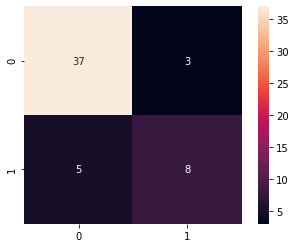

In [18]:
print_scores(wc_nb,y_val, X_val)

# Model 2: tfifd -> NBmodel

In [99]:
tfidf = TfidfVectorizer(preprocessor=tweet_preprocessor, smooth_idf=True)
nbc = MultinomialNB()
model2_pipeline = Pipeline([('tfidf', tfidf), ('nbc', nbc)])
model2_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'nbc', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'nbc__alpha', 'nbc__class_prior', 'nbc__fit_prior'])

In [100]:
model2_params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [1,2],
    'tfidf__min_df': [1,2],
    'tfidf__lowercase': [True, False],
    'tfidf__stop_words': ['english', None],
    'nbc__alpha': [0.1, 1]
}

In [101]:
tfidf_nbc = GridSearchCV(model2_pipeline, param_grid=model2_params, n_jobs=-1, verbose=3, cv=3, scoring=LogLoss)

In [102]:
tfidf_nbc.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.5523577  -0.54706108 -0.53765617 -0.52030903         nan         nan
         nan         nan -0.48286533 -0.47414087 -0.48250966 -0.46261489
 -0.53714925 -0.53949739 -0.53701194 -0.52856137 -0.5523577  -0.54706108
 -0.53765617 -0.52030903         nan         nan         nan         nan
 -0.48286533 -0.47414087 -0.48250966 -0.46261489 -0.53714925 -0.53949739
 -0.53701194 -0.52856137 -0.54541984 -0.54392239 -0.55286527 -0.55058439
         nan         nan         nan         nan -0.52107169 -0.51631301
 -0.53549894 -0.53371891 -0.52687303 -0.5218246  -0.52726574 -0.51926244
 -0.54541984 -0.54392239 -0.55286527 -0.55058439         nan         nan
         nan         nan -0.52107169 -0.51631301 -0.53549894 -0.53371891
 -0.52687303 -0.5218246  -0.52726574 -0.51926244]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function tweet_preprocessor at 0x7f8a88b64040>,
                                                        stop_words='english')),
                                       ('nbc', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nbc__alpha': [0.1, 1],
                         'tfidf__lowercase': [True, False],
                         'tfidf__max_df': [1, 2], 'tfidf__min_df': [1, 2],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__stop_words': ['english', None]},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
             verbose=3)

In [103]:
tfidf_nbc.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=2, ngram_range=(1, 2),
                                 preprocessor=<function tweet_preprocessor at 0x7f8a88b64040>)),
                ('nbc', MultinomialNB(alpha=0.1))])

              precision    recall  f1-score   support

  irrelevant       0.93      0.87      0.90        45
    relevant       0.45      0.62      0.53         8

    accuracy                           0.83        53
   macro avg       0.69      0.75      0.71        53
weighted avg       0.86      0.83      0.84        53

Log Loss: 0.48


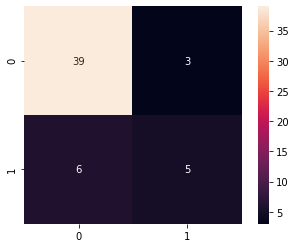

In [104]:
print_scores(tfidf_nbc, y_val, X_val)

# Model 3: CountVectorizer -> ComplementNB

In [19]:
count_vec = CountVectorizer(preprocessor=tweet_preprocessor, input='content', decode_error='ignore', stop_words='english', lowercase=True, strip_accents='ascii')
cnb = ComplementNB()
model3_pipeline = Pipeline(steps=[('wordcount', count_vec), ('bayes', cnb)])

In [20]:
params = {
    'wordcount__ngram_range': [(1,2), (1,1), (2,2)],
    'wordcount__min_df': [0, 1, 2, 3],
    'wordcount__stop_words': ['english', None],
    'wordcount__lowercase': [True, False],
    'bayes__alpha': [0.1, 0.01, 1, 2],
    'memory': ['wordcount']
}

In [21]:
model3_search = GridSearchCV(model3_pipeline, param_grid=params, n_jobs=-1, verbose=3)

In [22]:
model3_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=Pipeline(steps=[('wordcount',
                                        CountVectorizer(decode_error='ignore',
                                                        preprocessor=<function tweet_preprocessor at 0x7f9a0869db80>,
                                                        stop_words='english',
                                                        strip_accents='ascii')),
                                       ('bayes', ComplementNB())]),
             n_jobs=-1,
             param_grid={'bayes__alpha': [0.1, 0.01, 1, 2],
                         'memory': ['wordcount'],
                         'wordcount__min_df': [0, 1, 2, 3],
                         'wordcount__ngram_range': [(1, 2), (1, 1), (2, 2)]},
             verbose=3)

In [23]:
model3_search.best_estimator_

Pipeline(memory='wordcount',
         steps=[('wordcount',
                 CountVectorizer(decode_error='ignore', min_df=2,
                                 ngram_range=(2, 2),
                                 preprocessor=<function tweet_preprocessor at 0x7f9a0869db80>,
                                 stop_words='english', strip_accents='ascii')),
                ('bayes', ComplementNB(alpha=0.1))])

              precision    recall  f1-score   support

  irrelevant       0.76      0.97      0.86        40
    relevant       0.50      0.08      0.13        13

    accuracy                           0.75        53
   macro avg       0.63      0.53      0.50        53
weighted avg       0.70      0.75      0.68        53

Log Loss: 0.63


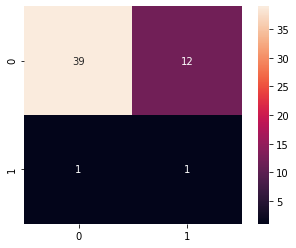

In [24]:
print_scores(model3_search, y_val, X_val)

# Model 4: CountVectorizer -> SVG

In [105]:
count_vec = CountVectorizer(preprocessor=tweet_preprocessor, input='content', decode_error='ignore', stop_words='english', lowercase=True, strip_accents='ascii')
svm = SVC(probability=True)
model4_pipeline = Pipeline([('count', count_vec), ('svm', svm)])
model4_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'count', 'svm', 'count__analyzer', 'count__binary', 'count__decode_error', 'count__dtype', 'count__encoding', 'count__input', 'count__lowercase', 'count__max_df', 'count__max_features', 'count__min_df', 'count__ngram_range', 'count__preprocessor', 'count__stop_words', 'count__strip_accents', 'count__token_pattern', 'count__tokenizer', 'count__vocabulary', 'svm__C', 'svm__break_ties', 'svm__cache_size', 'svm__class_weight', 'svm__coef0', 'svm__decision_function_shape', 'svm__degree', 'svm__gamma', 'svm__kernel', 'svm__max_iter', 'svm__probability', 'svm__random_state', 'svm__shrinking', 'svm__tol', 'svm__verbose'])

In [106]:
params = {
    'count__ngram_range': [(1,2), (1,1)],
    'count__min_df': [0, 1],
    'count__stop_words': ['english', None],
    'count__lowercase': [True, False],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__C': [1, 5, 10],
    'svm__class_weight': [None, 'balanced'],
}

In [107]:
model4_search = GridSearchCV(model4_pipeline, param_grid=params, n_jobs=-1, verbose=5, cv=3, scoring=LogLoss)

In [108]:
%%time
model4_search.fit(X_train, y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits
CPU times: user 6.58 s, sys: 428 ms, total: 7.01 s
Wall time: 16min 2s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('count',
                                        CountVectorizer(decode_error='ignore',
                                                        preprocessor=<function tweet_preprocessor at 0x7f8a88b64040>,
                                                        stop_words='english',
                                                        strip_accents='ascii')),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'count__lowercase': [True, False],
                         'count__min_df': [0, 1],
                         'count__ngram_range': [(1, 2), (1, 1)],
                         'count__stop_words': ['english', None],
                         'svm__C': [1, 5, 10],
                         'svm__class_weight': [None, 'balanced'],
                         'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring=make_scorer(log_loss, grea

In [109]:
model4_search.best_params_

{'count__lowercase': False,
 'count__min_df': 0,
 'count__ngram_range': (1, 1),
 'count__stop_words': 'english',
 'svm__C': 1,
 'svm__class_weight': None,
 'svm__kernel': 'sigmoid'}

In [121]:
model4_search.best_score_

-0.39381127486685424

              precision    recall  f1-score   support

  irrelevant       0.93      0.93      0.93        45
    relevant       0.62      0.62      0.62         8

    accuracy                           0.89        53
   macro avg       0.78      0.78      0.78        53
weighted avg       0.89      0.89      0.89        53

Log Loss: 0.39


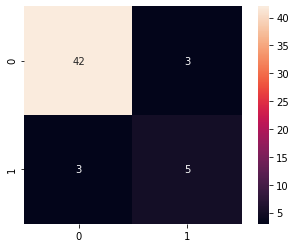

In [110]:
print_scores(model4_search, y_val, X_val)

In [111]:
count_vec = CountVectorizer(preprocessor=tweet_preprocessor, input='content', decode_error='ignore', stop_words='english', lowercase=True, strip_accents='ascii', min_df=0, ngram_range=(1,1))
svm = SVC(probability=True, class_weight='balanced', kernel='sigmoid', C=5)
svm_pipeline = Pipeline([('count', count_vec), ('svm', svm)])

In [112]:
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('count',
                 CountVectorizer(decode_error='ignore', min_df=0,
                                 preprocessor=<function tweet_preprocessor at 0x7f8a88b64040>,
                                 stop_words='english', strip_accents='ascii')),
                ('svm',
                 SVC(C=5, class_weight='balanced', kernel='sigmoid',
                     probability=True))])

              precision    recall  f1-score   support

  irrelevant       0.95      0.91      0.93        45
    relevant       0.60      0.75      0.67         8

    accuracy                           0.89        53
   macro avg       0.78      0.83      0.80        53
weighted avg       0.90      0.89      0.89        53

Log Loss: 0.35


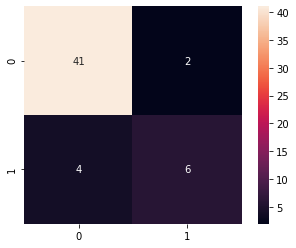

In [113]:
print_scores(svm_pipeline, y_val, X_val)

              precision    recall  f1-score   support

  irrelevant       0.95      0.91      0.93        45
    relevant       0.60      0.75      0.67         8

    accuracy                           0.89        53
   macro avg       0.78      0.83      0.80        53
weighted avg       0.90      0.89      0.89        53

Log Loss: 0.35


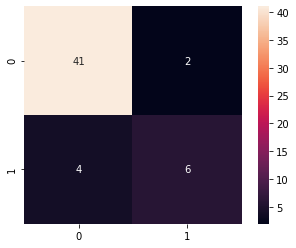

In [114]:
print_scores(svm_pipeline, y_val, X_val)

# Model5: Tfidf -> SVM

In [115]:
tfidf = TfidfVectorizer(preprocessor=tweet_preprocessor, smooth_idf=True, stop_words='english', lowercase=True)
svm = SVC(probability=True, class_weight='balanced')
model5_pipeline = Pipeline([('tfidf', tfidf), ('svm', svm)])
model5_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'svm', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'svm__C', 'svm__break_ties', 'svm__cache_size', 'svm__class_weight', 'svm__coef0', 'svm__decision_function_shape', 'svm__degree', 'svm__gamma', 'svm__kernel', 'svm__max_iter', 'svm__probability', 'svm__random_state', 'svm__shrinking', 'svm__tol', 'svm__verbose'])

In [116]:
params = {
    'tfidf__ngram_range': [(1,2), (1,1)],
    'tfidf__min_df': [0, 1],
    'tfidf__stop_words': ['english', None],
    'tfidf__lowercase': [True, False],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__C': [1, 5, 10],
}

In [117]:
model5_search = GridSearchCV(model5_pipeline, param_grid=params, n_jobs=-1, verbose=3, scoring=LogLoss)
model5_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(preprocessor=<function tweet_preprocessor at 0x7f8a88b64040>,
                                                        stop_words='english')),
                                       ('svm',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [1, 5, 10],
                         'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'tfidf__lowercase': [True, False],
                         'tfidf__min_df': [0, 1],
                         'tfidf__ngram_range': [(1, 2), (1, 1)],
                         'tfidf__stop_words': ['english', None]},
             scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
             verbose=3)

In [118]:
model5_search.best_params_

{'svm__C': 5,
 'svm__kernel': 'linear',
 'tfidf__lowercase': False,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

In [120]:
model5_search.best_score_

-0.4269014213250146

              precision    recall  f1-score   support

  irrelevant       0.95      0.87      0.91        45
    relevant       0.50      0.75      0.60         8

    accuracy                           0.85        53
   macro avg       0.73      0.81      0.75        53
weighted avg       0.88      0.85      0.86        53

Log Loss: 0.54


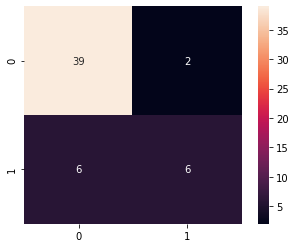

In [119]:
print_scores(model5_search, y_val, X_val)

## Final Model: countVector -> SVG

In [36]:
tfidf = CountVectorizer(preprocessor=tweet_preprocessor, stop_words='english', lowercase=True, min_df=0, ngram_range=(1,1))
svm = SVC(probability=True, class_weight='balanced', C=1, kernel='sigmoid')
final_svg = Pipeline([('tfidf', tfidf), ('svm', svm)])

In [37]:
# {'count__lowercase': False,
#  'count__min_df': 0,
#  'count__ngram_range': (1, 1),
#  'count__stop_words': 'english',
#  'svm__C': 1,
#  'svm__class_weight': None,
#  'svm__kernel': 'sigmoid'}

In [38]:
final_svg.fit(X_train, y_train)

/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Pipeline(steps=[('tfidf',
                 CountVectorizer(min_df=0,
                                 preprocessor=<function tweet_preprocessor at 0x7fdbbacd2040>,
                                 stop_words='english')),
                ('svm',
                 SVC(C=1, class_weight='balanced', kernel='sigmoid',
                     probability=True))])

              precision    recall  f1-score   support

  irrelevant       0.87      0.81      0.84        42
    relevant       0.43      0.55      0.48        11

    accuracy                           0.75        53
   macro avg       0.65      0.68      0.66        53
weighted avg       0.78      0.75      0.76        53

Log Loss: 0.48


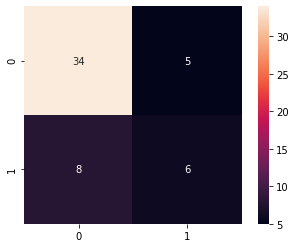

In [39]:
print_scores(final_svg, y_val, X_val)

              precision    recall  f1-score   support

  irrelevant       0.83      0.85      0.84        40
    relevant       0.50      0.46      0.48        13

    accuracy                           0.75        53
   macro avg       0.66      0.66      0.66        53
weighted avg       0.75      0.75      0.75        53

Log Loss: 0.40


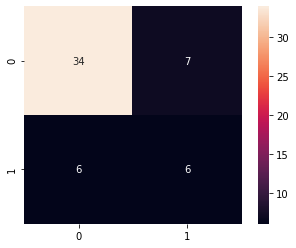

In [40]:
print_scores(final_svg, y_test, X_test)

# Final model: MultinomialNB

              precision    recall  f1-score   support

  irrelevant       0.90      0.95      0.92        38
    relevant       0.85      0.73      0.79        15

    accuracy                           0.89        53
   macro avg       0.87      0.84      0.85        53
weighted avg       0.88      0.89      0.88        53

Log Loss: 0.34


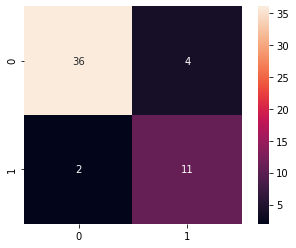

In [19]:
# Score for final model using test set
print_scores(wc_nb, y_test, X_test)

              precision    recall  f1-score   support

  irrelevant       0.93      0.88      0.90        42
    relevant       0.62      0.73      0.67        11

    accuracy                           0.85        53
   macro avg       0.77      0.80      0.78        53
weighted avg       0.86      0.85      0.85        53

Log Loss: 0.45


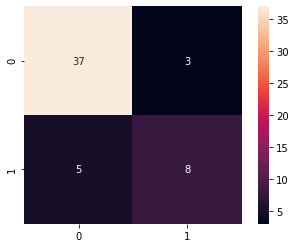

In [20]:
# Compare with validation set
print_scores(wc_nb, y_val, X_val)

# Save model

In [30]:
# import joblib

In [31]:
# with open('../bayes_model/best_bayes_pipeline.pkl', 'wb') as f:
#     joblib.dump(wc_nb, f)